## Imports and Configuration

In [22]:
import dolfinx as dlx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dolfinx.fem import petsc
from mpi4py import MPI
from petsc4py import PETSc

from ls_prior import components, fem, prior

sns.set_theme(style="ticks")

## Define a DolfinX Mesh

In [23]:
mesh = dlx.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([1, 1])],
    [100, 100],
    dlx.mesh.CellType.triangle,
)

## Define Necessary Settings for Prior Components

In [44]:
kappa, tau = 10.0, 0.1
mean_vector = np.zeros(mesh.geometry.x.shape[0], dtype=np.float64)
function_space = dlx.fem.functionspace(mesh, ("Lagrange", 2))

cg_solver_settings = components.InverseMatrixSolverSettings(
    solver_type=PETSc.KSP.Type.CG,
    preconditioner_type=PETSc.PC.Type.JACOBI,
    relative_tolerance=1e-6,
    absolute_tolerance=1e-8,
    max_num_iterations=10000,
)

amg_solver_settings = components.InverseMatrixSolverSettings(
    solver_type=PETSc.KSP.Type.CG,
    preconditioner_type=PETSc.PC.Type.GAMG,
    relative_tolerance=1e-6,
    absolute_tolerance=1e-8,
    max_num_iterations=10000,
)

## Assemble FEM Structures

In [45]:
mass_matrix_form, spde_matrix_form = fem.generate_forms(function_space, kappa, tau)
mass_matrix = petsc.assemble_matrix(dlx.fem.form(mass_matrix_form))
spde_matrix = petsc.assemble_matrix(dlx.fem.form(spde_matrix_form))
mass_matrix.assemble()
spde_matrix.assemble()
mass_matrix_factorization = fem.FEMMatrixFactorizationAssembler(
    mesh, function_space, mass_matrix_form
)
block_diagonal_matrix, dof_map_matrix = mass_matrix_factorization.assemble()
dof_map_matrix.transpose()
converter = fem.FEMConverter(function_space)

## Assemble Elementary PETSc Components

In [46]:
mass_matrix_component = components.Matrix(mass_matrix)
spde_matrix_component = components.Matrix(spde_matrix)
block_diagonal_matrix_component = components.Matrix(block_diagonal_matrix)
dof_map_matrix_component = components.Matrix(dof_map_matrix)
mass_matrix_inverse_component = components.InverseMatrixSolver(cg_solver_settings, mass_matrix)
spde_matrix_inverse_component = components.InverseMatrixSolver(amg_solver_settings, spde_matrix)

## Assemble Composite PETSc Components

In [47]:
precision_operator = components.PETScComponentComposition(
    spde_matrix_component, mass_matrix_inverse_component, spde_matrix_component
)
covariance_operator = components.PETScComponentComposition(
    spde_matrix_inverse_component, mass_matrix_component, spde_matrix_inverse_component
)
sampling_factor = components.PETScComponentComposition(
    block_diagonal_matrix_component, dof_map_matrix_component, spde_matrix_inverse_component
)

# Set Up Interfaces

In [48]:
precision_operator_interface = components.InterfaceComponent(precision_operator)
covariance_operator_interface = components.InterfaceComponent(covariance_operator)
sampling_factor_interface = components.InterfaceComponent(sampling_factor)

## Initialize Prior Object

In [49]:
bilaplace_prior = prior.Prior(
    mean_vector,
    precision_operator_interface,
    covariance_operator_interface,
    sampling_factor_interface,
    converter,
    seed=0,
)

## Test Prior functionality

In [50]:
rng = np.random.default_rng(0)

test_vector_1 = rng.random(mean_vector.shape)
test_vector_2 = 2 * rng.random(mean_vector.shape)
test_vector_3 = 3 * rng.random(mean_vector.shape)

cost = bilaplace_prior.evaluate_cost(test_vector_1)
grad = bilaplace_prior.evaluate_gradient(test_vector_2)
hvp = bilaplace_prior.evaluate_hessian_vector_product(test_vector_3)
sample = bilaplace_prior.generate_sample()

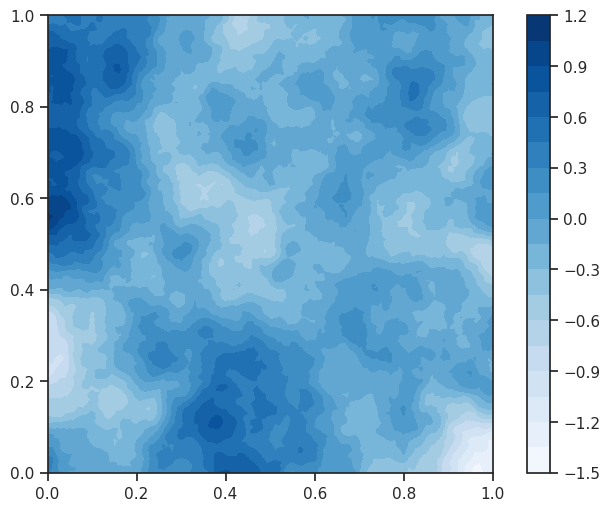

In [51]:
vertices = mesh.geometry.x
simplices = mesh.geometry.dofmap

fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")
contour_plot = ax.tricontourf(vertices[:, 0], vertices[:, 1], sample, levels=20, cmap="Blues")
plt.colorbar(contour_plot)